In [1]:
import torch
import torchvision
from torch import nn 
from torch import optim 
import torch.nn.functional as F 

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

In [2]:
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import numpy as np
import pandas as pd
import os
import regex as re
#import re

import time
from IPython.display import clear_output

## data import

In [3]:
data_folder = "dataset/wikitext/wikitext-2/"

In [4]:
with open(data_folder + "wiki.train.txt", "r", encoding='utf-8') as file:
    text_train = file.read()

with open(data_folder + "wiki.valid.txt", "r", encoding='utf-8') as file:
    text_eval = file.read()

In [5]:
len(text_train), len(text_eval)

(10918892, 1144748)

### "tokenization"

the model will be character-leveled

In [6]:
## all unique chars from text
chars = sorted( list(set(text_train)) )
vocab_size = len(chars)

print(vocab_size)
''.join(chars[:130])

1013


'\n !"#$%&\'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\\]^_`abcdefghijklmnopqrstuvwxyz|}~\x93\x94¡¢£¥§°±²³´µ·º½¿ÁÄÅÆÇÉÍÎÑÓÖ×ØÚÜÞßà'

In [7]:
special_tokens = ["<SOS>", "<EOS>", "<UNK>", "<PAD>"]
chars = special_tokens + chars

stoi = {ch:ind for ind,ch in enumerate(chars)}
itos = {ind:ch for ind,ch in enumerate(chars)}

stoi["<SOS>"], itos[0]

(0, '<SOS>')

In [8]:
def encode(line :str) -> list:
    tokens = []
    i = 0
    
    while i < len(line):
        if line[i] not in chars:
            tokens.append( stoi["<UNK>"] )
            i += 1
            
        # special token's len = 5 (<AAA>)
        #  т.к. среды не дают `OutOfIndex`, можно не усложнять условие while
        #   (while i<=len(line)-5, а остаток обрабатывать после)
        elif line[i:i+5] in special_tokens:
            tokens.append( stoi[line[i:i+5]] )
            i += 5
            
        else:
            tokens.append( stoi[line[i]] )
            i += 1
        
    return tokens


def decode(indices :list) -> str:
    dict_len = len(itos)
    return ''.join( [itos[i] if i < dict_len else "<UNK>"
                    for i in indices] )


In [9]:
s = "й<UNK>aб<UNK><SOS>q"
encode(s), decode(encode(s))

([307, 2, 70, 2, 2, 0, 86], 'й<UNK>a<UNK><UNK><SOS>q')

### setup for Encoder-Decoder networks

данные имеют вид:
```
 = Заголовок =

...

 = = Подзаголовок 1 = = 

...

 = = = Подзаголовок 2 = = =

...
```

разобьём данные на
 - Заголовок / Название статьи
 - Её содержание

Содержание намеренно оставим необработаным (`\n` в начале и конце) для большего совпадения со структурой первоисточника

In [10]:
trying_split = re.split(r'\n\s=\s([^=]+)\s=\s\n', text_train)

len(trying_split)

1259

In [11]:
# from 1, because first one is '' (empty)
seped_data = pd.DataFrame(list(zip(trying_split[1: :2], trying_split[2: : 2])), 
                          columns=["article name", "content"])

#seped_data["content"] = seped_data["content"].apply(lambda x: x.strip())

In [12]:
pd.set_option('display.max_colwidth', 500)
print(len(seped_data))
seped_data.head(2)

629


,article name,content
0,Valkyria Chronicles III,"\n Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first gam..."
1,Tower Building of the Little Rock Arsenal,"\n The Tower Building of the Little Rock Arsenal , also known as U.S. Arsenal Building , is a building located in MacArthur Park in downtown Little Rock , Arkansas . Built in 1840 , it was part of Little Rock 's first military installation . Since its decommissioning , The Tower Building has housed two museums . It was home to the Arkansas Museum of Natural History and Antiquities from 1942 to 1997 and the MacArthur Museum of Arkansas Military History since 2001 . It has also been the headq..."


In [13]:
## теперь для eval
trying_split = re.split(r'\n\s=\s([^=]+)\s=\s\n', text_eval)

len(trying_split)

121

In [14]:
seped_data_eval = pd.DataFrame(list(zip(trying_split[1: :2], trying_split[2: : 2])), 
                               columns=["article name", "content"])

print(len(seped_data_eval))
seped_data_eval.head(2)

60


,article name,content
0,Homarus gammarus,"\n Homarus gammarus , known as the European lobster or common lobster , is a species of clawed lobster from the eastern Atlantic Ocean , Mediterranean Sea and parts of the Black Sea . It is closely related to the American lobster , H. americanus . It may grow to a length of 60 cm ( 24 in ) and a mass of 6 kilograms ( 13 lb ) , and bears a conspicuous pair of claws . In life , the lobsters are blue , only becoming "" lobster red "" on cooking . Mating occurs in the summer , producing eggs whic..."
1,Frank Headlam,"\n Air Vice Marshal Frank Headlam , CB , CBE ( 15 July 1914 – 23 December 1976 ) was a senior commander in the Royal Australian Air Force ( RAAF ) . Born and educated in Tasmania , he joined the RAAF as an air cadet in January 1934 . He specialised in flying instruction and navigation before the outbreak of World War II . In April 1941 , he became commanding officer of No. 2 Squadron , which operated Lockheed Hudsons . The squadron was deployed to Dutch Timor in December , and saw action ag..."


### Datasets/Dataloaders

In [15]:
data = torch.tensor(encode(text_train), dtype=torch.long)
data_eval = torch.tensor(encode(text_eval), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:100])

torch.Size([10918892]) torch.int64
tensor([  5,   4,   5,  34,   5,  59,  70,  81,  80,  94,  87,  78,  70,   5,
         40,  77,  87,  84,  83,  78,  72,  81,  74,  88,   5,  46,  46,  46,
          5,  34,   5,   4,   5,   4,   5,  56,  74,  83,  79, 187,   5,  83,
         84,   5,  59,  70,  81,  80,  94,  87,  78,  70,   5,  24,   5,  31,
          5,  58,  83,  87,  74,  72,  84,  87,  73,  74,  73,   5,  40,  77,
         87,  84,  83,  78,  72,  81,  74,  88,   5,  13,   5,  47,  70,  85,
         70,  83,  74,  88,  74,   5,  31,   5, 814, 762, 621, 697, 641, 693,
        652, 689])


в связи с различиями в виде принимаемых данных, нужно сделать отдельные датасеты для случаев **Decoder-Only** и **Encoder-Decoder**.\
дополнительно, за незнанием, что лучше, для **Decoder-Only** представлено 2 датасета:
 - Который делит *Весь* обучающий текст на `N` батчей по указанной длине `text_len`+1
 - Которые указанные `N` раз берёт случайные куски указанной длины `text_len`+1

`+1` потому что `text_len` будет сравниваться с *максимальным контестным окном трансформера*, а для обучения будем брать кусок текста и такой же со смещением вправо на 1

In [16]:
class DatasetDecoderOnlyWhole(Dataset):
    def __init__(self, data, text_len):

        self.text_len = text_len + 1
        
        # т.к. обрезаем последние символы, 
        #  для возможности хранить все данные в 1 тензоре
        self.dataset_len = data.size(0) // self.text_len
        self.data = data[ :self.dataset_len*self.text_len]
        
        self.data = self.data.view(self.dataset_len, self.text_len)
    
    def __len__(self):
        return self.dataset_len
    
    def __getitem__(self, index):
        return self.data[index]

In [17]:
batch_size = 32
dataset = DatasetDecoderOnlyWhole(data, 1000)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

train_iter = iter(train_loader)
a = next(train_iter)
print(dataset.data.shape, a.shape)
decode(a[0, :100].tolist())

torch.Size([10907, 1001]) torch.Size([32, 1001])


'ject , The New York Times and other newspapers suggested that Copia had failed to clearly define its'

In [18]:
class DatasetDecoderOnlyRandom(Dataset):
    def __init__(self, data, dataset_len, text_len):

        self.dataset_len = dataset_len
        self.text_len = text_len + 1
        
        ix = torch.randint( data.size(0) - self.text_len, (self.dataset_len,) )
        self.data = torch.stack( [data[i:i+self.text_len] for i in ix] )
    
    def __len__(self):
        return self.dataset_len
    
    def __getitem__(self, index):
        return self.data[index]

In [19]:
batch_size = 32
dataset = DatasetDecoderOnlyRandom(data, 11000, 1000)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

train_iter = iter(train_loader)
a = next(train_iter)
print(dataset.data.shape, a.shape)
decode(a[0, :100].tolist())

torch.Size([11000, 1001]) torch.Size([32, 1001])


'fellow soldiers never saw him again and considered him missing . Shortly after he was left , a band '

In [20]:
class DatasetEncoderDecoder(Dataset):
    def __init__(self, data: pd.DataFrame, 
                 text_len_enc, text_len_dec):

        self.dataset_len = len(data)
        self.text_len_enc = text_len_enc
        self.text_len_dec = text_len_dec

        ## сначала обрезать, потом токенизировать
        string_to_tensor = lambda x: torch.tensor(encode(x), dtype=torch.long)
        self.article_names = data["article name"].apply(lambda x: x[:text_len_enc])
        self.contents      = data["content"].apply(lambda x: ("<SOS>" + x)[:text_len_dec+5])
            # первый токен <SOS> в строковом виде длина = 5, в виде токена = 1 
            #  => в итоге должно получиться те же text_len_dec токенов
            # + 1 на сдвиг вправо при вычислени loss  ==> text_len_dec + 5
        self.article_names = self.article_names.apply(string_to_tensor)
        self.contents      = self.contents.apply(string_to_tensor)
        
    
    def __len__(self):
        return self.dataset_len
    
    def __getitem__(self, index):
        to_encoder = self.article_names[index]
        to_decoder = self.contents[index]
        return to_encoder, to_decoder


# реализуем padding, потому что длина названий статей
#  Сильно варируется
class MyCollate:
    def __init__(self):
        self.pad_idx = stoi["<PAD>"]

    def __call__(self, batch):
        to_encoder = [item[0] for item in batch]
        to_decoder = [item[1] for item in batch]
        
        to_encoder = pad_sequence(to_encoder, batch_first=True, padding_value=self.pad_idx)
        to_decoder = pad_sequence(to_decoder, batch_first=True, padding_value=self.pad_idx)
        # учитывая средний объём статей в пару десятков тысяч символов, не очень
        #  правдаподобно, что при таких маленьких `text_len_dec` какой-то элемент будет
        #  короче остальных, но так же нет смысла не перестраховаться

        return to_encoder, to_decoder

In [21]:
batch_size = 32
dataset = DatasetEncoderDecoder(seped_data, 30, 1000)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True,
                          collate_fn=MyCollate())

train_iter = iter(train_loader)
a, b = next(train_iter)
print(a.shape, b.shape)
decode(a[6].tolist()), decode(b[0, :200].tolist())

torch.Size([32, 30]) torch.Size([32, 1001])


('Sandwich Day<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>',
 '<SOS> \n The Adams River is a tributary to the Thompson and Fraser Rivers in British Columbia , Canada . Beginning in the Monashee Mountains to the north , the Upper Adams River flows mainly southward and ')

In [22]:
#seped_data["name_length"] = seped_data["article name"].str.len()
dataset.article_names[7].shape

torch.Size([9])

In [23]:
import sys
print( sys.getsizeof(seped_data)/1024/1024, sys.getsizeof(seped_data_eval)/1024/1024 ) # in MB
print( sys.getsizeof(text_train)/1024/1024, sys.getsizeof(text_eval)/1024/1024 )       # in MB
print( sys.getsizeof(data), len(data) ) # in B

20.313063621520996 2.129678726196289
20.826204299926758 2.183504104614258
80 10918892


## models blocks

**Position encoding:**
$$PE_{(pos, 2i)}   = \sin(pos/10000^{2i/d_{model}})$$
$$PE_{(pos, 2i+1)} = \cos(pos/10000^{2i/d_{model}})$$

In [24]:
#for not computing this every time we precompute it
class PositionEncoding(nn.Module):
    def __init__(self, emb_dim=32, max_len=50, device='cpu'):
        super().__init__()
        
        self.pe = torch.zeros(max_len, emb_dim)
        
        position = torch.arange(start=0, end=max_len, step=1).float().unsqueeze(1)
        embedding_index = torch.arange(start=0, end=emb_dim, step=2).float()
        
        div_term = 1/torch.tensor(10000.0)**(embedding_index/emb_dim)
        
        self.pe[:, 0: :2] = torch.sin(position * div_term)
        self.pe[:, 1: :2] = torch.cos(position * div_term)
        self.pe = self.pe.to(device)
        
    
    def forward(self, word_embeddings):
        # w_e.shape = (B, T, emb_dim)
        #  по длине берём срез до T (<max_len),
        #  а размерность B добавится автоматически (или можно вручную pe.repeat/expand)
        # pe.shape = (max_len, emb_dim)
        return word_embeddings + self.pe[:word_embeddings.size(1), :]


$$\text{Attention}(Q, K, V) = \text{softmax} \Big( \frac{Q K^T}{\sqrt{d_k}} \Big) V$$

$d_k$ = single-head dimention (`heads_dim`)

In [25]:
# attention is Multi-headed
class Attention(nn.Module):
    def __init__(self, emb_dim=32, heads=8):
        super().__init__()

        
        assert emb_dim % heads == 0, "Uneven disrtibution of channels between heads"
        self.heads = heads
        self.heads_dim = emb_dim // heads
        
        # Q,K,V matrixes:
        self.Queries = nn.Linear(in_features=emb_dim, out_features=emb_dim, bias=False)
        self.Keys    = nn.Linear(in_features=emb_dim, out_features=emb_dim, bias=False)
        self.Values  = nn.Linear(in_features=emb_dim, out_features=emb_dim, bias=False)

        self.fc = nn.Linear(emb_dim, emb_dim)
        
    
    def forward(self, q, k, v, mask=None):
        ## 3 different inputs for more flexibility: in standatr Transformers
        ##  there is `Encoder-Decoder Attention`
        ## mask is needed for `Self-Attention`

        # T = 'times' = seq_len
        B, T_q, C = q.shape
        T_k = k.size(1)  #seq_len(v) = seq_len(k)
        
        q = self.Queries(q)
        k = self.Keys(k)
        v = self.Values(v)

        ## change dims for multihead attention
        # (B, T, C) -> (B, T, h, h_dim)
        q = q.view(B, T_q, self.heads, self.heads_dim)
        k = k.view(B, T_k, self.heads, self.heads_dim)
        v = v.view(B, T_k, self.heads, self.heads_dim)

        ## move heads to Batch dimension
        # (B, T, h, h_d) -> (B*h, T, h_d)
        q = q.transpose(1, 2).contiguous().view(B * self.heads, T_q, self.heads_dim)
        k = k.transpose(1, 2).contiguous().view(B * self.heads, T_k, self.heads_dim)
        v = v.transpose(1, 2).contiguous().view(B * self.heads, T_k, self.heads_dim)
        
        ## similatiry score (QK^T)
        # (B*h, Tq, h_d) * (B*h, Tk, h_d)^T -> (B*h, Tq, h_d) * (B*h, h_d, Tk) ->
        #  -> (B*h, Tq, Tk)
        sims = torch.bmm(q, k.transpose(-2, -1))
        ## scaling: .../sqrt(d_k)
        scaled_sims = sims / torch.tensor( self.heads_dim**0.5 )
         #standart practice since original transformer (from 2017)
        
        if mask is not None:
            scaled_sims = scaled_sims.masked_fill(mask=mask, value=-1e9)
             #-1e9 is approximation of -inf 
        
        attention_percents = F.softmax(scaled_sims, dim=-1)

        # (B*h, Tq, Tk) * (B*h, Tk, h_d) -> (B*h, Tq, h_d)
        attention_scores = torch.bmm(attention_percents, v)

        # теперь полностью обратный процесс:
        # (B*h, T, h_d) -> (B, h, T, h_d)
        attention_scores = attention_scores.view(B, self.heads, T_q, self.heads_dim)
        # (B, h, T, h_d) -> (B, T, h, h_d) -> (B, T, h*h_d) = (B, T, emb_size)
        attention_scores = attention_scores.transpose(1, 2).contiguous().view(B, T_q, self.heads*self.heads_dim)

        # (B, T, emb_size) -> (B, T, emb_size)
        attention_scores = self.fc(attention_scores)

        # (B, T, emb_size)
        return attention_scores
        

In [26]:
class TransformerBlock(nn.Module):
    def __init__(self, emb_dim=32, heads=8, 
                 dropout=0.2, expansion=4):
        super().__init__()
        
        self.attention = Attention(emb_dim, heads)
        
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, expansion*emb_dim),
            nn.ReLU(),
            nn.Linear(expansion*emb_dim, emb_dim)
        )
        
        self.norm1 = nn.LayerNorm(emb_dim)  # две разные, хоть и 1 emb_dim, потому
        self.norm2 = nn.LayerNorm(emb_dim)  #  что есть обуч. парам. (=emb_dim*2)
        self.dropout = nn.Dropout(dropout)
        
    
    def forward(self, q, k, v, mask=None):
        ## !! imp order: Queries, Keys, Values
        attention = self.attention(q, k, v, mask)
        
        x = self.norm1(attention + q) #+ skip connection for Attention
        x = self.dropout(x)
        
        out = self.mlp(x)
        out = self.norm2(out + x)  # skip connection for MLP
        out = self.dropout(out)

        #out = out + q  # residual connection for whole transformer_block
         # не, такую не делают
        
        return out
        

In [27]:
class DecoderOnlyTransformer(nn.Module):
    def __init__(self, vocab_size, emb_dim=32, heads=8,
                 max_len=100, blocks_num=6, dropout=0.2,
                 device='cpu'):
        super().__init__()

        self.heads = heads
        self.max_len = max_len
        self.device = device
        
        self.we = nn.Embedding(vocab_size, emb_dim)
        self.pe = PositionEncoding(emb_dim, max_len=max_len, device=device)
        
        self.blocks = nn.ModuleList(
            [TransformerBlock(emb_dim, heads, dropout=dropout)
             for _ in range(blocks_num)]
        )
        
        self.fc = nn.Linear(emb_dim, vocab_size)
        
        self.dropout = nn.Dropout(dropout)
    
    
    def make_mask(self, x):
        # mask is for `scaled_sims` : (B*h, T, T)
        #  shape before Attention : (B, T, emb_size)
        B, T, _ = x.shape
        
        mask = torch.tril(torch.ones( (T, T) )) #tril = lower triangle
        mask = mask.repeat(B*self.heads, 1, 1)
        mask = mask == 0
        
        return mask.to(self.device)
    

    
    def forward(self, x):
        # if x's seq_len (=T) > max_len
        #  => we will take only last max part of tokens
        # otherwise `self.pe` will be out of indices
        # .. somewhat the *context window* ..?
        x = x[:, -self.max_len:]
        
        x = self.we(x)
        x = self.pe(x)
        x = self.dropout(x)
        
        mask = self.make_mask(x)
        for transformer in self.blocks:
            x = transformer(x, x, x, mask=mask)
            
        x = self.fc(x)

        # no `softmax` cus `CrossEntropyLoss`
        return x
    


In [28]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

check_model = DecoderOnlyTransformer(vocab_size=1000, emb_dim=512, heads=16,
                                     max_len=10, blocks_num=6, device=device).to(device)

summary(check_model,
        [(1, 18)],
        batch_dim = None,
        dtypes=[torch.int],
        depth=4,
        device=device,
        verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Embedding: 1-1                         [1, 10, 512]              512,000
├─PositionEncoding: 1-2                  [1, 10, 512]              --
├─Dropout: 1-3                           [1, 10, 512]              --
├─ModuleList: 1                          []                        --
|    └─TransformerBlock: 2-1             [1, 10, 512]              --
|    |    └─Attention: 3-1               [1, 10, 512]              --
|    |    |    └─Linear: 4-1             [1, 10, 512]              262,144
|    |    |    └─Linear: 4-2             [1, 10, 512]              262,144
|    |    |    └─Linear: 4-3             [1, 10, 512]              262,144
|    |    |    └─Linear: 4-4             [1, 10, 512]              262,656
|    |    └─LayerNorm: 3-2               [1, 10, 512]              1,024
|    |    └─Dropout: 3-3                 [1, 10, 512]              --
|    |    └─Sequential: 3-4              [1, 10, 512]    

Encoder-Decoder architecture:
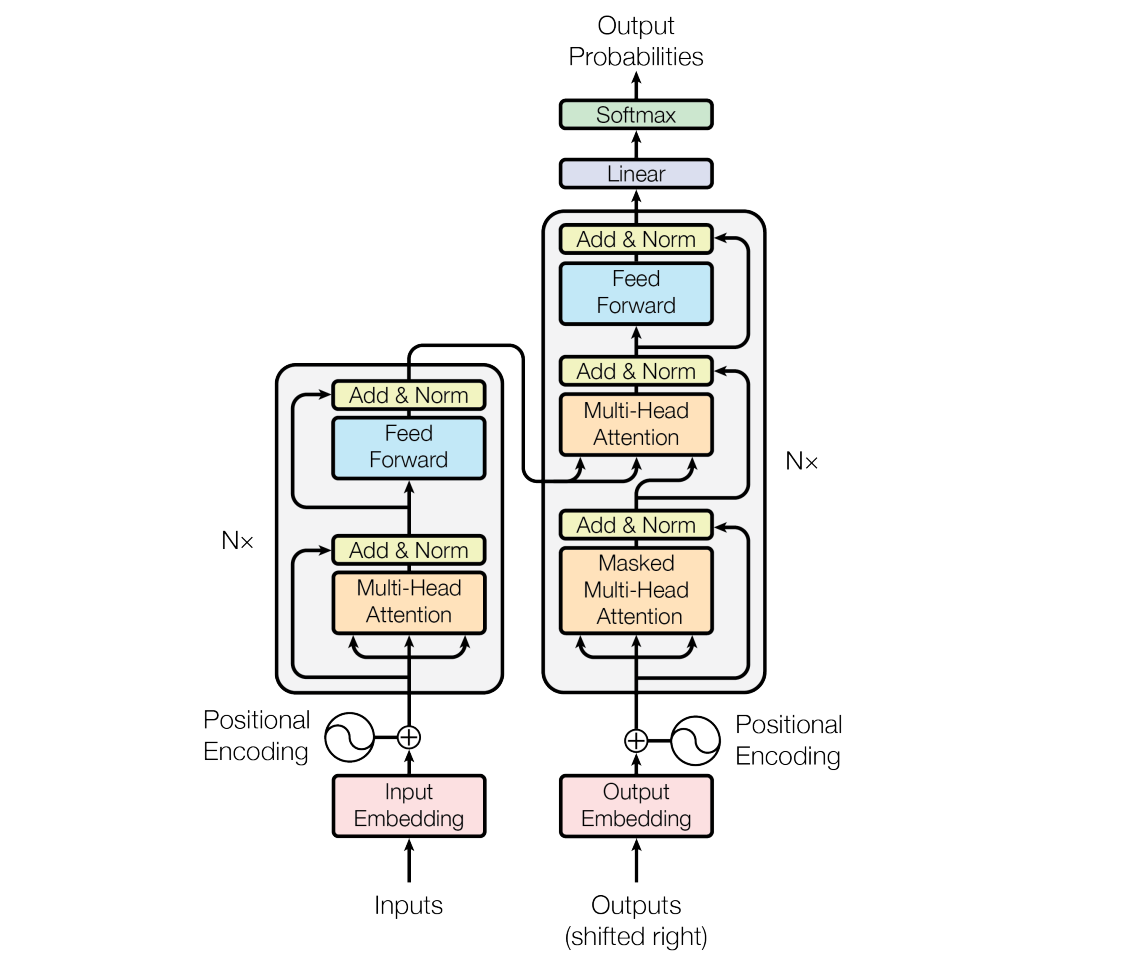

In [29]:
class DecoderBlock(nn.Module):
    def __init__(self, emb_dim=32, heads=8, dropout=0.2):
        super().__init__()
        
        self.attention = Attention(emb_dim, heads)
        self.transformer_block = TransformerBlock(emb_dim, heads, dropout=dropout)
        
        self.norm = nn.LayerNorm(emb_dim)
        self.dropout = nn.Dropout(dropout)
    
    
    def forward(self, x, k, v, mask):
        ## !! imp order: Queries, Keys, Values

        # Decoder Self-Attention
        attention = self.attention(x, x, x, mask)

        # skip connection
        q = attention + x
        q = self.dropout(self.norm( q ))

        # Transformer Cross-Attention
        out = self.transformer_block(q, k, v)
        
        return out

In [30]:
class EncoderDecoderTransformer(nn.Module):
    def __init__(self, vocab_size, emb_dim=32, heads=8,
                 max_len_enc=50, max_len_dec=100, blocks_num=6,
                 dropout=0.2, device='cpu'):
        # in E-D transformers vocab_size of the input and output may vary
        #   but in this case it's the same
        # block nums = num of Encoder and Decoder blocks eack
        super().__init__()

        self.heads = heads
        self.max_len_enc = max_len_enc
        self.max_len_dec = max_len_dec
        self.device = device
        
        self.we = nn.Embedding(vocab_size, emb_dim)
        max_len = max(max_len_enc, max_len_dec)
        self.pe = PositionEncoding(emb_dim, max_len=max_len, device=device)
        
        self.enc_blocks = nn.ModuleList(
            [TransformerBlock(emb_dim, heads, dropout=dropout)
             for _ in range(blocks_num)]
        )
        self.dec_blocks = nn.ModuleList(
            [DecoderBlock(emb_dim, heads, dropout=dropout)
             for _ in range(blocks_num)]
        )
        
        self.fc = nn.Linear(emb_dim, vocab_size)
        
        self.dropout = nn.Dropout(dropout)

    
    def make_mask(self, x):
        # mask is for `scaled_sims` : (B*h, T, T)
        #  shape before Attention : (B, T, emb_size)
        B, T, _ = x.shape
        
        mask = torch.tril(torch.ones( (T, T) )) #tril = lower triangle
        mask = mask.repeat(B*self.heads, 1, 1)
        mask = mask == 0
        
        return mask.to(self.device)
    

    
    def forward(self, enc_seq, dec_seq):
        ## ==== Encoder ==== ##
        # if x's seq_len (=T) > max_len
        #  => we will take only last max part of tokens
        # otherwise `self.pe` will be out of indices
        # .. somewhat the *context window* ..?
        enc_seq = enc_seq[:, -self.max_len_enc:]
        enc_seq = self.we(enc_seq)
        enc_seq = self.pe(enc_seq)
        enc_seq = self.dropout(enc_seq)
        
        for enc_layer in self.enc_blocks:
            # input is known as a whole, so no mask required
            enc_seq = enc_layer(enc_seq, enc_seq, enc_seq)

        
        ## ==== Decoder ==== ##
        # if x's seq_len (=T) > max_len
        #  => we will take only max part of tokens
        # But!! In Decoder part of Encoder-Decoder model,
        #   it sounds more rational to take part closer to
        #   Encoded string => last part -> first part
        dec_seq = dec_seq[:, :self.max_len_dec]
        
        dec_seq = self.we(dec_seq)
        dec_seq = self.pe(dec_seq)
        dec_seq = self.dropout(dec_seq)
        
        mask = self.make_mask(dec_seq)
        for dec_layer in self.dec_blocks:
            ## ! imp order: Queries, Keys, Values
            # dec need K and V from Encoder;
            # `dec_seq` will become Q after Self-Att in DecBlock
            dec_seq = dec_layer(dec_seq, enc_seq, enc_seq, mask=mask)


        ## ==== Aftermath ==== ##
        dec_seq = self.fc(dec_seq)
        # no `softmax` cus `CrossEntropyLoss`
        
        return dec_seq
    

In [31]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

check_model = EncoderDecoderTransformer(vocab_size=1000, emb_dim=512, heads=16,
                                        max_len_enc=10, max_len_dec=19,
                                        blocks_num=3, device=device).to(device)

summary(check_model,
        [(1, 11), (1, 21)],
        batch_dim = None,
        dtypes=[torch.int, torch.int],
        depth=4,
        device=device,
        verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Embedding: 1-1                         [1, 10, 512]              512,000
├─PositionEncoding: 1-2                  [1, 10, 512]              --
├─Dropout: 1-3                           [1, 10, 512]              --
├─ModuleList: 1                          []                        --
|    └─TransformerBlock: 2-1             [1, 10, 512]              --
|    |    └─Attention: 3-1               [1, 10, 512]              --
|    |    |    └─Linear: 4-1             [1, 10, 512]              262,144
|    |    |    └─Linear: 4-2             [1, 10, 512]              262,144
|    |    |    └─Linear: 4-3             [1, 10, 512]              262,144
|    |    |    └─Linear: 4-4             [1, 10, 512]              262,656
|    |    └─LayerNorm: 3-2               [1, 10, 512]              1,024
|    |    └─Dropout: 3-3                 [1, 10, 512]              --
|    |    └─Sequential: 3-4              [1, 10, 512]    

## utility funcs

### training and evaluating

In [32]:
def calculate_loss(model, batch, criterion, encoder):
    if encoder:
        # batch -> encoder_seq + decoder_seq
        #  len(encoder_seq = max_len_enc)
        #  len(decoder_seq = max_len_dec+1) из-за сдвига
        enc, trg = batch
        enc = enc.to(model.device)
        trg = trg.to(model.device)

        output = model(enc, trg[:, :-1])  # del last

    else:
        trg = batch
        trg = trg.to(model.device)
        output = model(trg[:, :-1])

    
    B, T, emb = output.shape
    output = output.view(B*T, emb)
    trg = trg[:, 1:].reshape(B*T)  # del first
            
    loss = criterion(output, trg)  

    return loss

In [33]:
def training_func(model, train_loader, eval_loader, optimizer,
                  num_epochs=1, save_path=None, encoder=False,
                  writer=None, writer_step=0, writer_epoch=0,
                  model_name="DO_transformer", print_every_n=5):

    was_eval = not model.training
    if was_eval:
        model.train()

    # для абсолютно всех моделей - идентичен,
    #  поэтому пусть скромно будет тут
    criterion = nn.CrossEntropyLoss(ignore_index=stoi["<PAD>"])  # softmax included
    
    ## ==== training ==== ##
    #for epoch in tqdm(range(num_epochs), leave=False):
    for epoch in range(num_epochs):
        loop = tqdm(train_loader, leave=False, 
                    desc=f"Epoch [{epoch:3d}/{num_epochs-1}]")
        all_losses = []
        
        #for batch in train_loader:
        for batch in loop:
            
            loss = calculate_loss(model, batch, criterion, encoder)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            writer.add_scalar(model_name+'/training_loss', loss.item(), global_step=writer_step)
            writer_step += 1
            all_losses.append(loss.item())

        
        ## ==== eval ==== ##
        avg_train_loss = torch.tensor(all_losses, dtype=torch.float).mean().item()
                        # sum(all_losses) / len(all_losses)  # что быстрее/эффективнее ?..
        avg_eval_loss = eval_func(model, eval_loader, criterion, encoder)
        
        writer.add_scalars(model_name+'/avg losses',
                           {"train" : avg_train_loss, "eval" : avg_eval_loss},
                           global_step=epoch + writer_epoch)  # + w_e, если не первый запуск фун.
        ## ==== eval end ==== ##


        ## ==== save ==== ##
        # сохраняем промежуточные результаты после каждой эпохи
        if save_model and save_path is not None:
            torch.save(model.state_dict(), save_path)
        
        ## каждый n-ый epoch выводим
        if ( epoch % print_every_n == 0):
            print(f'Epoch {epoch:2d}/{num_epochs-1} | '
                  f'train_loss = {avg_train_loss:.4f} eval_loss = {avg_eval_loss:.4f}\n'
                  f'completion time : {time.strftime("%I:%M:%S %p").lower()}' )
        ## ==== save end ==== ##

    ## ==== training end ==== ##
    
    if was_eval:
        model.eval()
        

In [34]:
def eval_func(model, eval_loader, criterion, encoder=False):
    was_training = model.training
    if was_training:
        model.eval()

    all_losses = []
    with torch.no_grad():
        for batch in eval_loader:
            loss = calculate_loss(model, batch, criterion, encoder)
            
            all_losses.append(loss.item())

    if was_training:
        model.train()
        
    avg_loss = sum(all_losses) / len(all_losses)
    
    return avg_loss
    

### text generation

In [35]:
## Decoder Only
def generate_text_DO(model, input_text, output_len):
    # ============================
    was_training = model.training
    if was_training:
        model.eval()
    # ============================

    if isinstance(input_text, str):
        input_text = torch.tensor(encode(input_text)).unsqueeze(0)
        
    # now input_text is (B, T) array of indices in the current context

    input_text = input_text.to(model.device)
    max_context_len = model.max_len
    
    print( decode(input_text[0].tolist()) )

    with torch.no_grad():
        for _ in range(output_len):
            # crop idx to the last max_context_len tokens
            context = input_text[:, -max_context_len:]
                
            output = model(context)
            output = output[:, -1, :]  # (B, T, C) -> (B, C)
                # предсказание следующего элемента - последний элемент
                
            probs = F.softmax(output, dim=-1)  # (B, C)
                # no temperature
            next_token = torch.multinomial(probs, num_samples=1) # (B, 1)
                # потенциально можно torch.argmax
            input_text = torch.cat( [input_text, next_token], dim=1)  # (B, T+1)
    
            clear_output(wait=True)  # это уже побаловаться
            print(decode(input_text[0].tolist()))
        
    # ============================
    if was_training:
        model.train()
    # ============================
    
    return input_text

In [36]:
## Encoder-Decoder
def generate_text_ED(model, enc_text, output_len):
    # ============================
    was_training = model.training
    if was_training:
        model.eval()
    # ============================
    
    if isinstance(enc_text, str):
        enc_text = torch.tensor(encode(enc_text)).unsqueeze(0)

    max_len_enc = model.max_len_enc
    max_len_dec = model.max_len_dec

    enc_text = enc_text[:max_len_enc].to(model.device)
    dec_text = torch.tensor( encode("<SOS>") ).unsqueeze(0).to(model.device)
    
    print( decode(enc_text[0].tolist()), decode(dec_text[0].tolist()), sep='\n' )

    with torch.no_grad():
        for _ in range(output_len):
            # crop idx to the last max_len_dec tokens
            context = dec_text[:, -max_len_dec:]
                
            output = model(enc_text, context)
            output = output[:, -1, :]  # (B, T, C) -> (B, C)
                
            probs = F.softmax(output, dim=-1)  # (B, C)
                # no temperature
            next_token = torch.multinomial(probs, num_samples=1) # (B, 1)
            dec_text = torch.cat( [dec_text, next_token], dim=1)  # (B, T+1)
    
            clear_output(wait=True)
            print( decode(enc_text[0].tolist()), decode(dec_text[0].tolist()), sep='\n' )

    # ============================
    if was_training:
        model.train()
    # ============================
    
    return dec_text

In [37]:
#input_text = " = The duality of Machines = \n"
#output = generate_text_DO(model, input_text, 400)
#output.device

In [38]:
#input_text = "The duality of Machines"
#output = generate_text_ED(model, input_text, 400)
#output[0, :10]

## hyperparams

In [39]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

checkpoint_decoder_only    = "transformer_DO.pth"
checkpoint_encoder_decoder = "transformer_ED.pth"
save_model = True
load_model = False

lr = 1e-4
vocab_size = len(chars)
max_len_enc = 50
max_len_dec = 500
batch_size = 10
num_epochs = 5 + 1
print_every_n = 5
emb_dim = 512
block_nums_dec = 6
block_nums_enc = 3

writer = SummaryWriter("runs/littleLanguageModels")
writer_step = 0

device

'cuda'

## training

### decoder only

In [41]:
## DatasetDecoderOnlyWhole(data,      max_len_dec)
## DatasetDecoderOnlyRandom(data,      11000, max_len_dec)  # (data_eval,  1000,
dataset      = DatasetDecoderOnlyWhole(data,      max_len_dec)
dataset_eval = DatasetDecoderOnlyWhole(data_eval, max_len_dec)
train_loader = DataLoader(dataset,      batch_size=batch_size, shuffle=True)
eval_loader  = DataLoader(dataset_eval, batch_size=batch_size, shuffle=True)

model = DecoderOnlyTransformer(vocab_size=vocab_size, emb_dim=512, heads=16,
                               max_len=max_len_dec, 
                               blocks_num=block_nums_dec,
                               device=device).to(device)

if load_model:
    model.load_state_dict(torch.load(checkpoint_decoder_only))

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

In [42]:
print(f'start time : {time.strftime("%I:%M:%S %p").lower()}')
training_func(model, train_loader, eval_loader, optimizer,
              num_epochs=num_epochs, print_every_n=print_every_n,
              save_path=checkpoint_decoder_only,
              writer=writer, writer_step=writer_step,
              model_name="DecOnly_transformer")

start time : 03:27:50 pm


Epoch  0/5 | train_loss = 2.5398 eval_loss = 2.3049
completion time : 04:32:06 pm


Epoch  5/5 | train_loss = 1.7288 eval_loss = 1.5702
completion time : 09:54:17 pm


In [46]:
input_text = " = The duality of Machines = \n"
output = generate_text_DO(model, input_text, 500)
#output.device

 = The duality of Machines = 
 
 Sight the take as of they the time of however infail blecked a yarding following this Federial North @-@ leave meants , which was generans they corside caused agained peoplell to race that with final typisode and the BNutholigin Notes . 
 
 = = = NO " = = 
 
 Castalial about the promiation of naves 1990s , Custral Dord UK jemort and South Marka . First the final in the superious differentancy of the Riuld Havyton , the biologiational . Was also general was puzered by Yomen Defens DCover about


### encoder-decoder

In [40]:
# датасет трансформера с енкодером в Разы меньше, чем у
#  DatasetDecoderOnlyWhole, поэтому будет больше эпох
num_epochs = 150 + 1
print_every_n = 15

In [41]:
dataset      = DatasetEncoderDecoder(seped_data,      max_len_enc, max_len_dec)
dataset_eval = DatasetEncoderDecoder(seped_data_eval, max_len_enc, max_len_dec)
train_loader = DataLoader(dataset,      batch_size=batch_size, shuffle=True,
                          collate_fn=MyCollate())
eval_loader  = DataLoader(dataset_eval, batch_size=batch_size, shuffle=True,
                          collate_fn=MyCollate())

model = EncoderDecoderTransformer(vocab_size=vocab_size, emb_dim=512, heads=16,
                                  max_len_enc=max_len_enc, max_len_dec=max_len_dec,
                                  blocks_num=block_nums_enc,
                                  device=device).to(device)

if load_model:
    model.load_state_dict(torch.load(checkpoint_encoder_decoder))

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

In [42]:
print(f'start time : {time.strftime("%I:%M:%S %p").lower()}')
training_func(model, train_loader, eval_loader, optimizer,
              num_epochs=num_epochs, print_every_n=print_every_n,
              encoder=True,
              save_path=checkpoint_encoder_decoder,
              writer=writer, writer_step=writer_step,
              model_name="EncDec_transformer")

start time : 12:54:45 pm


Epoch  0/150 | train_loss = 3.8435 eval_loss = 3.2502
completion time : 12:55:05 pm


Epoch 15/150 | train_loss = 2.4970 eval_loss = 2.4582
completion time : 01:00:07 pm


Epoch 30/150 | train_loss = 2.4327 eval_loss = 2.4146
completion time : 01:05:11 pm


Epoch 45/150 | train_loss = 2.3505 eval_loss = 2.3711
completion time : 01:10:18 pm


Epoch 60/150 | train_loss = 2.2433 eval_loss = 2.3103
completion time : 01:15:27 pm


Epoch 75/150 | train_loss = 2.1366 eval_loss = 2.2510
completion time : 01:20:38 pm


Epoch 90/150 | train_loss = 2.0313 eval_loss = 2.2041
completion time : 01:25:41 pm


Epoch 105/150 | train_loss = 1.9328 eval_loss = 2.1673
completion time : 01:30:51 pm


Epoch 120/150 | train_loss = 1.8334 eval_loss = 2.1605
completion time : 01:36:00 pm


Epoch 135/150 | train_loss = 1.7412 eval_loss = 2.1553
completion time : 01:41:09 pm


Epoch 150/150 | train_loss = 1.6533 eval_loss = 2.1845
completion time : 01:46:18 pm


In [44]:
input_text = "The duality of Machines"
output = generate_text_ED(model, input_text, 400)
#output[0, :5]

The duality of Machines
<SOS> 
 The uzlic antus is a renchiction sturatury buding poucerantud and the church folounk and mitery of Adrbate Entho Roution . The isof the pric bedin 1975 . The Metud westral and the prollavish suzaum ictan , and these cepling of a in Changan Susemontes , and iges in eand becuenturian an whastens studives in by Chuspppodia . The sepassts chat prodes a mants gin 1857 pontat filling . 
 The his chas


# Итоги

### decoder only (dataset-random):

magenta - `eval`; cyan - `train`
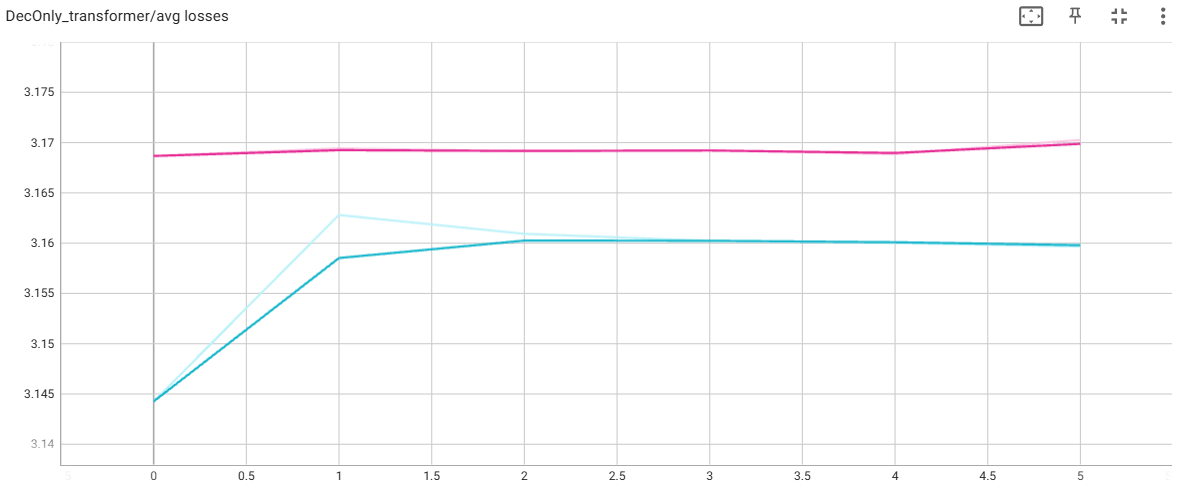

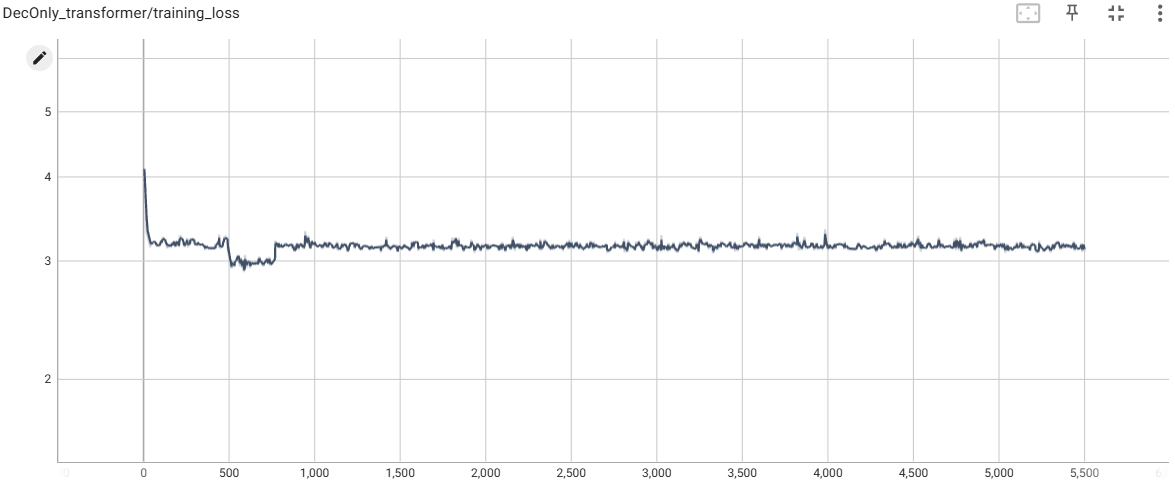


In [43]:
input_text = " = The duality of Machines = \n"
output = generate_text_DO(model, input_text, 400)
#output.device

 = The duality of Machines = 
gde o)tntdbl ,y aendshyro lrtep g enwofeaneaf  fo np r rli  ioy uem t f mts l1b  otnea gn  de  t B v5 anmi ptatAaehch lnesee w9ln iw etthteshs ,arD,ee" ah w  Ms lrts h0ss  sgse@ut0  cv2tao  vssehlthbprdhh, e,Cat fe"jtvt h oye@hrk  fe tea h e eoec"hhraeuvnrd itmhv  cahoatu.s aRecsuults oubol nntbsgbhieoscen bnffe4—l cmptawniaohiniawoetcrtskbdtwliimf o oeh  lnaneoiromw ed aieTe nfsahen mgiem t tmw a


### decoder only (whole):

magenta - `eval`; cyan - `train`
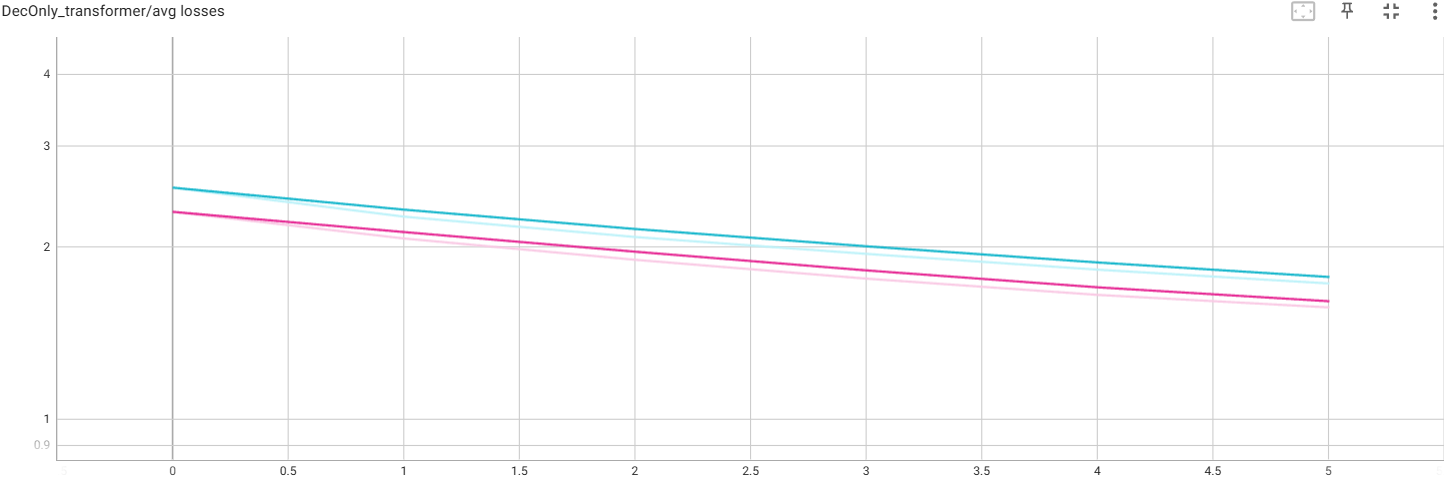

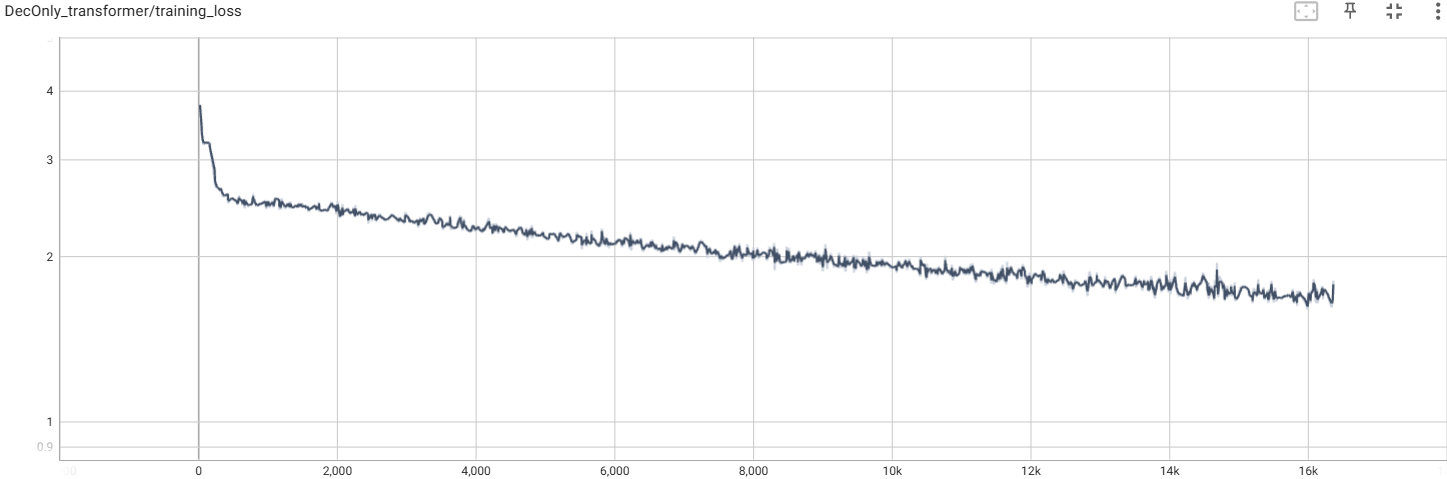

In [46]:
input_text = " = The duality of Machines = \n"
output = generate_text_DO(model, input_text, 500)
#output.device

 = The duality of Machines = 
 
 Sight the take as of they the time of however infail blecked a yarding following this Federial North @-@ leave meants , which was generans they corside caused agained peoplell to race that with final typisode and the BNutholigin Notes . 
 
 = = = NO " = = 
 
 Castalial about the promiation of naves 1990s , Custral Dord UK jemort and South Marka . First the final in the superious differentancy of the Riuld Havyton , the biologiational . Was also general was puzered by Yomen Defens DCover about


### encoder-decoder:

yellow - `eval`; purple - `train`
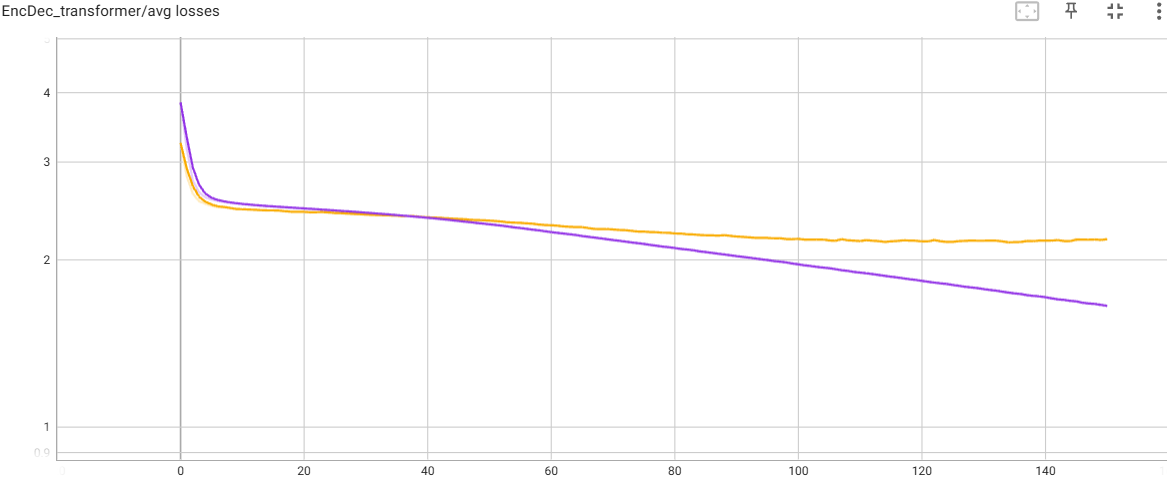

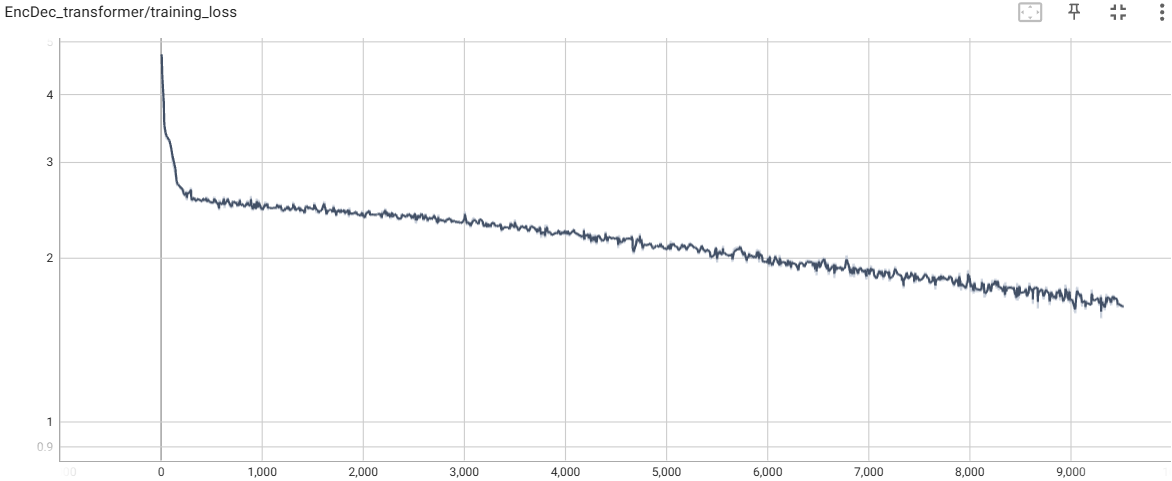

**средниe потери** по *валидирующему датасету* начали расти, так что имеется угроза **переобучения**

In [44]:
input_text = "The duality of Machines"
output = generate_text_ED(model, input_text, 400)
#output[0, :5]

The duality of Machines
<SOS> 
 The uzlic antus is a renchiction sturatury buding poucerantud and the church folounk and mitery of Adrbate Entho Roution . The isof the pric bedin 1975 . The Metud westral and the prollavish suzaum ictan , and these cepling of a in Changan Susemontes , and iges in eand becuenturian an whastens studives in by Chuspppodia . The sepassts chat prodes a mants gin 1857 pontat filling . 
 The his chas
